In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip -q install gputil
!pip -q install psutil
!pip -q install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

Gen RAM Free: 12.8 GB  | Proc size: 158.7 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Loading data

In [3]:
!pip install kaggle
import os
os.environ['KAGGLE_USERNAME'] = "pawankumarsahu" 
os.environ['KAGGLE_KEY'] = ""
!kaggle datasets download -d cdeotte/jpeg-melanoma-256x256
!unzip -q jpeg-melanoma-256x256.zip
!rm jpeg-melanoma-256x256.zip

 97% 770M/791M [00:17<00:00, 48.8MB/s]
100% 791M/791M [00:17<00:00, 46.8MB/s]


In [4]:
!kaggle datasets download -d nroman/melanoma-hairs

  0% 0.00/26.2k [00:00<?, ?B/s]
100% 26.2k/26.2k [00:00<00:00, 11.0MB/s]


In [5]:
!unzip -q melanoma-hairs.zip
!rm melanoma-hairs.zip
!mkdir melanoma-hairs
!mv 1.png /content/melanoma-hairs
!mv 2.png /content/melanoma-hairs
!mv 3.png /content/melanoma-hairs
!mv 4.png /content/melanoma-hairs
!mv 5.png /content/melanoma-hairs

# Importing packages

In [6]:
!pip install efficientnet_pytorch torchtoolbox
import os
import seaborn as sns
from efficientnet_pytorch import EfficientNet
import gc
import datetime
import warnings
import numpy as np
import pandas as pd
from random import randint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchtoolbox.transform as transforms
from torch.optim.optimizer import Optimizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold, KFold
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, roc_auc_score
from matplotlib.pyplot import imread
from pylab import *
from albumentations import (Cutout,JpegCompression,ShiftScaleRotate,CenterCrop,RandomRotate90,Flip,VerticalFlip,Blur,RandomContrast,HueSaturationValue,RandomGamma,Rotate,RandomBrightness,HorizontalFlip, Normalize, Resize, Compose, GaussNoise,Transpose,RandomBrightnessContrast,RandomCrop)
from albumentations.pytorch import ToTensor
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, models, transforms
import time
import copy
!pip install timm
import timm
import rangelars_lookahead_ralamb
from rangelars_lookahead_ralamb import *

     |████████████████████████████████| 61kB 4.7MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=3787ca452b3f90a41f17441486cee6bc4211e96dc27c5a75f310823bb6ac6262
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 215kB 6.8MB/s 


In [7]:
def seed_all(seed=8):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  #random.seed(seed)
  torch.backends.cudnn.enabled=False
  torch.backends.cudnn.deterministic=True

seed_all(47)

In [8]:
warnings.simplefilter('ignore')
torch.manual_seed(47)
np.random.seed(47)

# Csv file

In [9]:
train_csv = pd.read_csv('/content/train.csv')
test_csv = pd.read_csv('/content/test.csv')
test_csv['target']=""
test_csv.target=0

In [10]:
# tmp = pd.read_csv('tmp_train.csv')
# train_csv['fold'] = tmp['tfrecord']
# del tmp
# gc.collect();

In [11]:
print('train image count--',len(train_csv),'\t test image count--',len(test_csv))
train_csv.target.value_counts(normalize=True)

train image count-- 33126 	 test image count-- 10982


0    0.98237
1    0.01763
Name: target, dtype: float64

In [12]:
train_csv.head()

image_name  patient_id     sex  ...  tfrecord width height
0  ISIC_2637011  IP_7279968    male  ...         0  6000   4000
1  ISIC_0015719  IP_3075186  female  ...         0  6000   4000
2  ISIC_0052212  IP_2842074  female  ...         6  1872   1053
3  ISIC_0068279  IP_6890425  female  ...         0  1872   1053
4  ISIC_0074268  IP_8723313  female  ...        11  6000   4000

[5 rows x 11 columns]

# Extra AUG

In [ ]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        n_hairs = random.randint(0, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [ ]:
class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
                        (0, 0, 0), # color
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

# Building datasets

In [13]:
class dataset(Dataset):
  def __init__(self, csv_file, dir_path, phase):
    self.csv_file = csv_file
    self.dir_path = dir_path
    self.phase = phase
    self.transform = get_transforms(self.phase)

  def __len__(self):
    return len(self.csv_file)

  def __getitem__(self,idx):
    img_path = os.path.join(self.dir_path, self.csv_file.iloc[idx, 0]+'.jpg')
    image = imread(img_path)
    label = self.csv_file.target.iloc[idx]
    aug_img = self.transform(image=image)
    image = aug_img["image"]
    return image,label

def get_transforms(phase):
  t_list=[]
  if phase=='train' or phase=='test':
    t_list.extend([
                   #RandomBrightness(limit=0.3, p=0.5),
                   #AdvancedHairAugmentation(hairs_folder='melanoma-hairs'),
                   Rotate(limit=90, p=0.5),
                   ##RGBShift(r_shift_limit=50, g_shift_limit=30, b_shift_limit=40, p=1),
                   #RandomGamma(gamma_limit=(80,165), p=0.5),
                   HorizontalFlip(p=0.5),
                   VerticalFlip(p=0.5),
                   #Flip(p=0.5),
                   RandomRotate90(p=0.5),
                   ShiftScaleRotate(shift_limit=0.02,scale_limit=(0.95,1.075),p=0.5),
                   #JpegCompression(quality_lower=50, quality_upper=100, p=0.5),
                   #transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
                   Cutout(num_holes=12, max_h_size=2, max_w_size=2, p=0.5),
                   #transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
                   ##HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=30, p=1),
                   #RandomContrast(limit=0.3, p=0.5),
                   RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
                   ])
  t_list.extend([#CenterCrop(height=205, width=205, p=1),
                 #Resize(224, 224, interpolation=1, p=1),    ## 16x16, 64x64 , 128x100
                 Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
                 ToTensor()])
  return  Compose(t_list)

In [14]:
### creating train and test datasets
train_dataset = dataset(train_csv,'/content/train/','train')
test_dataset = dataset(test_csv,'/content/test/','test')
dataset_sizes={'train':len(train_dataset),'test':len(test_dataset)}
print(dataset_sizes)

{'train': 33126, 'test': 10982}


In [15]:
### visualising datasets
a=randint(0,20000)
print("VISUALISING TRAIN DATASET")
for i in range(a,a+10):
  image, label = train_dataset[i]
  print(i,'\t', image.shape,'\t', label)
print("\nVISUALISING TEST DATASET")
b=randint(0,10000)
for i in range(b,b+10):
  image, label = test_dataset[i]
  print(i,'\t', image.shape,'\t', label)

VISUALISING TRAIN DATASET
5255 	 torch.Size([3, 256, 256]) 	 0
5256 	 torch.Size([3, 256, 256]) 	 0
5257 	 torch.Size([3, 256, 256]) 	 0
5258 	 torch.Size([3, 256, 256]) 	 0
5259 	 torch.Size([3, 256, 256]) 	 0
5260 	 torch.Size([3, 256, 256]) 	 0
5261 	 torch.Size([3, 256, 256]) 	 0
5262 	 torch.Size([3, 256, 256]) 	 0
5263 	 torch.Size([3, 256, 256]) 	 0
5264 	 torch.Size([3, 256, 256]) 	 0

VISUALISING TEST DATASET
1926 	 torch.Size([3, 256, 256]) 	 0
1927 	 torch.Size([3, 256, 256]) 	 0
1928 	 torch.Size([3, 256, 256]) 	 0
1929 	 torch.Size([3, 256, 256]) 	 0
1930 	 torch.Size([3, 256, 256]) 	 0
1931 	 torch.Size([3, 256, 256]) 	 0
1932 	 torch.Size([3, 256, 256]) 	 0
1933 	 torch.Size([3, 256, 256]) 	 0
1934 	 torch.Size([3, 256, 256]) 	 0
1935 	 torch.Size([3, 256, 256]) 	 0


# Visualising Batch

In [ ]:
visual_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

0 torch.Size([16, 3, 256, 256]) torch.Size([16])
1 torch.Size([16, 3, 256, 256]) torch.Size([16])
2 torch.Size([16, 3, 256, 256]) torch.Size([16])
3 torch.Size([16, 3, 256, 256]) torch.Size([16])
batch size-- 16
img size-- 256


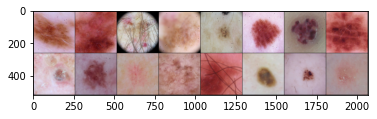

In [ ]:
### visualing batches
def show_batch(sample_batch):
  img_batch,label_batch = sample_batch
  print('batch size--',len(img_batch))
  print('img size--',img_batch.size(2))
  grid_border_size = 2
  grid = torchvision.utils.make_grid(img_batch)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i, sample_batch in enumerate(visual_loader):
  img, label = sample_batch
  print(i, img.size(), label.shape)
  if i==3:
    show_batch(sample_batch)
    break

del img, label, visual_loader 

# Training + prediction

In [16]:
class Net(nn.Module):
  def __init__(self,arch):
    super(Net,self).__init__()
    self.arch=arch
    num_ftrs = self.arch._fc.in_features
    self.arch._fc = nn.Linear(in_features=num_ftrs, out_features=1, bias=True)
  
  def forward(self,x):
    x = self.arch(x)
    return x

In [17]:
arch = EfficientNet.from_pretrained('efficientnet-b5')
skf = KFold(n_splits=5,shuffle=True,random_seed=47)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


In [18]:
gc.collect()

3

In [19]:
#pred_dict = {}
epochs = 5#5#12
model_path='model.pth'
patience = 6#6
tta=11
device = torch.device("cuda")
oof = np.zeros((len(train_csv), 1)) 
preds=torch.zeros((len(test_dataset),1), dtype=torch.float32, device=device)

for fold, (idxT, idxV) in enumerate(skf.split(np.arange(15)), 1):
  print("="*20, 'Fold', fold, '='*20)
  
  train_idx = train_csv.loc[train_csv['tfrecord'].isin(idxT)].index
  val_idx = train_csv.loc[train_csv['tfrecord'].isin(idxV)].index
  #best_val = None
  best_loss = None
  pat = patience
  # if fold<3:
  #   epochs=10
  # else:
  #   epochs=15
  
  model = Net(arch=arch)
  # if fold<4:
  model = torch.load('/content/drive/My Drive/b5new_1_'+str(fold)+model_path)
  # else:
  # model = torch.load('/content/drive/My Drive/g8_retryagain_new_'+str(fold)+model_path)
  model = model.to(device)
  optim = Ranger(model.parameters(),lr=0.00012)#over9000,0.0006#sgd,0.001#adamw,0.0001,0.001####0.00012,1.92e-7
  scheduler = ReduceLROnPlateau(optimizer=optim, factor=0.2, mode='max', patience=1,verbose=True)#0.2,2
  criterion = nn.BCEWithLogitsLoss()#smoothning

  train = dataset(train_csv.iloc[train_idx].reset_index(drop=True),'/content/train/','train')
  val = dataset(train_csv.iloc[val_idx].reset_index(drop=True),'/content/train/','val')

  train_loader = DataLoader(dataset=train, batch_size=34, shuffle=True, num_workers=4)
  val_loader = DataLoader(dataset=val, batch_size=8, shuffle=False, num_workers=4)
  test_loader = DataLoader(dataset=test_dataset, batch_size=40, shuffle=False, num_workers=4)

  if fold>0:
    for epoch in range(epochs):
      start_time = time.time()
      correct = 0
      epoch_loss = 0
      val_loss = 0
      model.train()
        
      for x,y in train_loader:
        x=torch.tensor(x,device=device, dtype=torch.float32)
        y=torch.tensor(y,device=device, dtype=torch.float32)
        optim.zero_grad()
        z= model(x)
        loss = criterion(z, y.unsqueeze(1))
        loss.backward()
        optim.step()
        pred = torch.round(torch.sigmoid(z))
        correct += (pred.cpu()==y.cpu().unsqueeze(1)).sum().item()
        epoch_loss += loss.item()
      train_acc = correct/len(train_idx)
      
      model.eval()
      val_preds = torch.zeros((len(val_idx),1),dtype=torch.float32, device=device)
      with torch.no_grad():
        for j,(x_val,y_val) in enumerate(val_loader):
          x_val=torch.tensor(x_val, device=device, dtype=torch.float32)
          y_val=torch.tensor(y_val, device=device, dtype=torch.float32)
          z_val = model(x_val)
          val_pred = torch.sigmoid(z_val)
          val_preds[j*x_val.shape[0]:(j+1)*x_val.shape[0]] = val_pred
        val_acc = accuracy_score(train_csv.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
        val_roc = roc_auc_score(train_csv.iloc[val_idx]['target'].values, val_preds.cpu())

        print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
              epoch + 1, 
              epoch_loss, 
              train_acc, 
              val_acc, 
              val_roc, 
              str(datetime.timedelta(seconds=time.time() - start_time))))
        
        scheduler.step(val_roc)
        if not best_loss:
          best_val = val_roc
          best_loss=epoch_loss
          torch.save(model, model_path)
          continue
        if epoch_loss<=best_loss:
          best_val=val_roc
          best_loss=epoch_loss
          pat=patience
          torch.save(model, model_path)
          print('UPDATED ^')
        # elif (best_val-val_roc)<0.001 and epoch_loss<best_loss:
        #   best_val=val_roc
        #   best_loss=epoch_loss
        #   pat=patience
        #   torch.save(model, model_path)
        #   print('UPDATED ^')
        else:
          pat-=1
          if pat==0:
            print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
            break
    model = torch.load(model_path)
    torch.save(model,'/content/drive/My Drive/b5new_2_'+str(fold)+model_path)
  model.eval()
  val_preds = torch.zeros((len(val_idx),1), dtype=torch.float32, device=device)
  with torch.no_grad():
    for j, (x_val, y_val) in enumerate(val_loader):
      x_val = torch.tensor(x_val, device=device, dtype=torch.float32)
      y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
      z_val = model(x_val)
      val_pred = torch.sigmoid(z_val)
      val_preds[j*x_val.shape[0]:j*x_val.shape[0] + x_val.shape[0]] = val_pred
    oof[val_idx] = val_preds.cpu().numpy()
    if fold>0:
      del x,y
    del  train, val, train_loader, val_loader, x_val,y_val
    gc.collect()
    for _ in range(tta):
      for i,(x_test,y_test) in enumerate(test_loader):
        x_test = torch.tensor(x_test, device=device, dtype=torch.float32)
        z_test = model(x_test)
        z_test = torch.sigmoid(z_test)
        preds[i*x_test.shape[0]:(i+1)*x_test.shape[0]] += z_test
    preds/=tta###write code such that for every tta even if we get one true then thats imp
    #pred_dict[str(fold)]=preds
  del x_test,y_test,test_loader
  gc.collect()

preds/= skf.n_splits

==================== Fold 1 ====================
Epoch 001: | Loss: 36.281 | Train acc: 0.984 | Val acc: 0.989 | Val roc_auc: 0.955 | Training time: 0:16:53.485925
Epoch 002: | Loss: 34.409 | Train acc: 0.985 | Val acc: 0.987 | Val roc_auc: 0.940 | Training time: 0:16:49.880988
UPDATED ^
Epoch 003: | Loss: 34.168 | Train acc: 0.985 | Val acc: 0.986 | Val roc_auc: 0.942 | Training time: 0:16:51.931898
Epoch     3: reducing learning rate of group 0 to 2.4000e-05.
UPDATED ^
Epoch 004: | Loss: 29.494 | Train acc: 0.987 | Val acc: 0.988 | Val roc_auc: 0.947 | Training time: 0:16:57.595631
UPDATED ^
Epoch 005: | Loss: 26.938 | Train acc: 0.988 | Val acc: 0.989 | Val roc_auc: 0.949 | Training time: 0:16:49.411131
Epoch     5: reducing learning rate of group 0 to 4.8000e-06.
UPDATED ^
==================== Fold 2 ====================
Epoch 001: | Loss: 29.874 | Train acc: 0.988 | Val acc: 0.995 | Val roc_auc: 0.997 | Training time: 0:16:51.445224
Epoch 002: | Loss: 31.588 | Train acc: 0.987 | V

# Final validation score

In [20]:
print('OOF: {:.3f}'.format(roc_auc_score(train_csv['target'], oof)))

OOF: 0.962


In [21]:
oof_csv = pd.read_csv('train.csv')
oof_csv['target'] = oof
oof_csv.to_csv('/content/drive/My Drive/b5new_2_oof.csv', index=False)

# Saving csv

In [22]:
sub_csv = pd.read_csv('sample_submission.csv')
sub_csv['target'] = preds.cpu()

In [23]:
test_csv.head()

image_name  patient_id     sex  ...  width height  target
0  ISIC_0052060  IP_3579794    male  ...   6000   4000       0
1  ISIC_0052349  IP_7782715    male  ...   6000   4000       0
2  ISIC_0058510  IP_7960270  female  ...   6000   4000       0
3  ISIC_0073313  IP_6375035  female  ...   6000   4000       0
4  ISIC_0073502  IP_0589375  female  ...   1920   1080       0

[5 rows x 8 columns]

In [24]:
sub_csv.target= torch.tensor(sub_csv.target)[:,0]

In [25]:
sub_csv.head()

image_name    target
0  ISIC_0052060  0.000166
1  ISIC_0052349  0.000068
2  ISIC_0058510  0.000124
3  ISIC_0073313  0.000195
4  ISIC_0073502  0.002020

In [26]:
sub_csv.to_csv('/content/drive/My Drive/sub_b5new_2_.csv', index=False)